In [842]:
# Importing Libraries

import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# ML Libraries
from sklearn.linear_model import LinearRegression

from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import collections
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection
from sklearn.datasets import make_classification
from sklearn.neighbors import LocalOutlierFactor
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

# Loading the Data and EDA

In [843]:
import pandas as pd

missing_value = ["n.a.","NA","n/a", "na", "NaN", "NULL", "None"]

data = pd.read_excel("Dataset.xlsx", na_values = missing_value)
data.head()

,Customer_ID,Gender,Age,Boxes_Purchased_Cnt,Last_Purchase_Date,Unique_Emails_Sent,Open_Rate,Click_to_Open_Rate,Email_Unsubscribe_Ind,Email_Unsubscribe_Date,Customer_Status,Status_Cancel_Date
0,1,F,25 to 34,2,2020-11-01 00:00:00,10 to 19,0,0,0,NaT,active,NaT
1,2,M,45 to 54,1,2020-05-01 00:00:00,10 to 19,>50% to 75%,>0% to 10%,1,2020-08-04,cancel,2020-05-01
2,3,M,35 to 44,2,Before 2020,20 to 29,>25% to 50%,>25%,0,NaT,active,NaT
3,4,F,55+,2,2020-08-01 00:00:00,20 to 29,0,0,1,2020-09-02,active,NaT
4,5,M,25 to 34,2,2020-02-01 00:00:00,NaN,0,0,1,2019-08-31,active,NaT


In [844]:
data.isnull().max()

Customer_ID               False
Gender                     True
Age                       False
Boxes_Purchased_Cnt       False
Last_Purchase_Date        False
Unique_Emails_Sent         True
Open_Rate                 False
Click_to_Open_Rate        False
Email_Unsubscribe_Ind     False
Email_Unsubscribe_Date     True
Customer_Status           False
Status_Cancel_Date         True
dtype: bool

It can be seen that the dataset has missing values for features: Gender, Email_Unsubscribe_Date and Status_Cancel_Date. Before creating any models, we need to impute these missing values with an appropriate method.

In [845]:
len(data)

4000

It looks like there aren't many customers that have canceled the subscription. Let's take a look at the distribution of the Customer_Status : 

In [846]:
print('Active Subscriptions are', round(data['Customer_Status'].str.contains('active').sum()/len(data) * 100,2), '% of the dataset')
print('Canceled Subscriptions are', round(data['Customer_Status'].str.contains('cancel').sum()/len(data) * 100,2), '% of the dataset')

Active Subscriptions are 90.52 % of the dataset
Canceled Subscriptions are 9.48 % of the dataset


Text(0.5, 1.0, 'Distribution of 2 classes \n (1: Active || 0: Canceled)')

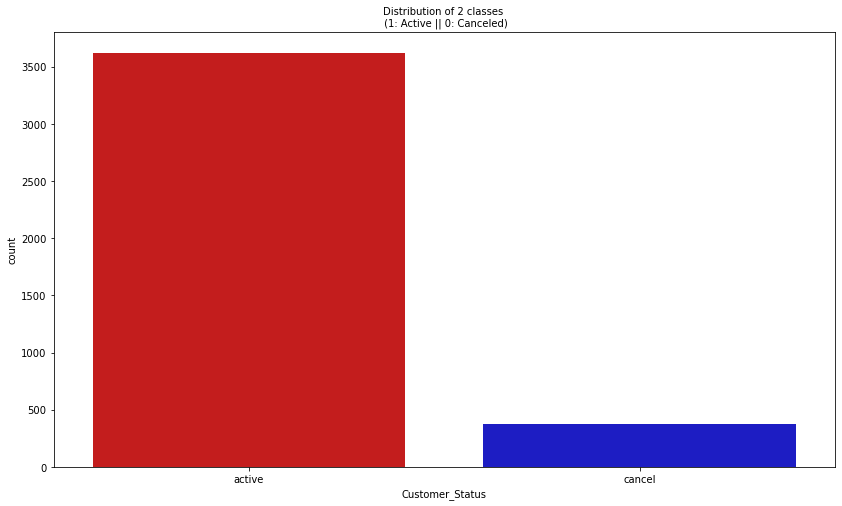

In [847]:
colors = ["#DF0101", "#0101DF"]
sns.countplot('Customer_Status', data=data, palette=colors)
plt.title('Distribution of 2 classes \n (1: Active || 0: Canceled)', fontsize=10)

 From the above exhibit, we can see that the data is skewed with respect to the customer status
. Therefore, if we want to predict cancelation for a new customer, we should first take care of the imbalanced structure of the data
 by resampling methods and create an even distribution for both classes ( active, cancel). One way of doing so is to undersample 
the active customers and have a 50/50 distribution of both classes and then train a model.

In [848]:
print(data.isnull().sum())

Customer_ID                  0
Gender                     255
Age                          0
Boxes_Purchased_Cnt          0
Last_Purchase_Date           0
Unique_Emails_Sent         196
Open_Rate                    0
Click_to_Open_Rate           0
Email_Unsubscribe_Ind        0
Email_Unsubscribe_Date    3476
Customer_Status              0
Status_Cancel_Date        3627
dtype: int64


# Imputing Gender

In [849]:
# Finding the mode of Gender
data['Gender'].mode()

0    F
dtype: object

In [850]:
data['Gender'].fillna('F', inplace=True)


In [851]:
print(data.isnull().sum())

Customer_ID                  0
Gender                       0
Age                          0
Boxes_Purchased_Cnt          0
Last_Purchase_Date           0
Unique_Emails_Sent         196
Open_Rate                    0
Click_to_Open_Rate           0
Email_Unsubscribe_Ind        0
Email_Unsubscribe_Date    3476
Customer_Status              0
Status_Cancel_Date        3627
dtype: int64


# Modifying Age from Range to Mean

In [852]:
data['Age'].unique()

array(['25 to 34', '45 to 54', '35 to 44', '55+', '18 to 24'],
      dtype=object)

In [853]:
def age_mean(x):
    if x == '25 to 34':
        return int((25+34)/2)
    elif x == '45 to 54':
        return int((45+54)/2)
    elif x == '35 to 44':
        return int((35+44)/2)
    elif x == '18 to 24':
        return int((18+24)/2)
    elif x == '55+':
        return 55


In [854]:
data['mean_age'] = data['Age'].apply(age_mean)
mean_age = data['mean_age']

In [855]:
data.drop(['Age'], axis = 1 , inplace = True)

In [856]:
data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Unique_Emails_Sent,Open_Rate,Click_to_Open_Rate,Email_Unsubscribe_Ind,Email_Unsubscribe_Date,Customer_Status,Status_Cancel_Date,mean_age
0,1,F,2,2020-11-01 00:00:00,10 to 19,0,0,0,NaT,active,NaT,29
1,2,M,1,2020-05-01 00:00:00,10 to 19,>50% to 75%,>0% to 10%,1,2020-08-04,cancel,2020-05-01,49
2,3,M,2,Before 2020,20 to 29,>25% to 50%,>25%,0,NaT,active,NaT,39
3,4,F,2,2020-08-01 00:00:00,20 to 29,0,0,1,2020-09-02,active,NaT,55
4,5,M,2,2020-02-01 00:00:00,NaN,0,0,1,2019-08-31,active,NaT,29


# Modifying Unique Emails Sent from Range to Mean

In [857]:
data['Unique_Emails_Sent'] = data['Unique_Emails_Sent'].fillna(0)
data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Unique_Emails_Sent,Open_Rate,Click_to_Open_Rate,Email_Unsubscribe_Ind,Email_Unsubscribe_Date,Customer_Status,Status_Cancel_Date,mean_age
0,1,F,2,2020-11-01 00:00:00,10 to 19,0,0,0,NaT,active,NaT,29
1,2,M,1,2020-05-01 00:00:00,10 to 19,>50% to 75%,>0% to 10%,1,2020-08-04,cancel,2020-05-01,49
2,3,M,2,Before 2020,20 to 29,>25% to 50%,>25%,0,NaT,active,NaT,39
3,4,F,2,2020-08-01 00:00:00,20 to 29,0,0,1,2020-09-02,active,NaT,55
4,5,M,2,2020-02-01 00:00:00,0,0,0,1,2019-08-31,active,NaT,29


In [858]:
print(data.isnull().sum())

Customer_ID                  0
Gender                       0
Boxes_Purchased_Cnt          0
Last_Purchase_Date           0
Unique_Emails_Sent           0
Open_Rate                    0
Click_to_Open_Rate           0
Email_Unsubscribe_Ind        0
Email_Unsubscribe_Date    3476
Customer_Status              0
Status_Cancel_Date        3627
mean_age                     0
dtype: int64


In [859]:
data['Unique_Emails_Sent'].unique()

array(['10 to 19', '20 to 29', 0, '30 to 49', 'Less than 10', '50+'],
      dtype=object)

In [860]:
def email_mean(y):
    if y == '10 to 19':
        return int((10+19)/2)
    elif y == '20 to 29':
        return int((20+29)/2)
    elif y == '30 to 49':
        return int((30+49)/2)
    elif y == 'Less than 10':
        return 10
    elif y == '50+':
        return 50
    elif y == 0 :
        return 0

In [861]:
data['mean_num_email_sent'] = data['Unique_Emails_Sent'].apply(email_mean)
mean_num_email_sent = data['mean_num_email_sent']

In [862]:
data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Unique_Emails_Sent,Open_Rate,Click_to_Open_Rate,Email_Unsubscribe_Ind,Email_Unsubscribe_Date,Customer_Status,Status_Cancel_Date,mean_age,mean_num_email_sent
0,1,F,2,2020-11-01 00:00:00,10 to 19,0,0,0,NaT,active,NaT,29,14
1,2,M,1,2020-05-01 00:00:00,10 to 19,>50% to 75%,>0% to 10%,1,2020-08-04,cancel,2020-05-01,49,14
2,3,M,2,Before 2020,20 to 29,>25% to 50%,>25%,0,NaT,active,NaT,39,24
3,4,F,2,2020-08-01 00:00:00,20 to 29,0,0,1,2020-09-02,active,NaT,55,24
4,5,M,2,2020-02-01 00:00:00,0,0,0,1,2019-08-31,active,NaT,29,0


In [863]:
data.drop(['Unique_Emails_Sent'], axis = 1 , inplace = True)

In [864]:
data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Open_Rate,Click_to_Open_Rate,Email_Unsubscribe_Ind,Email_Unsubscribe_Date,Customer_Status,Status_Cancel_Date,mean_age,mean_num_email_sent
0,1,F,2,2020-11-01 00:00:00,0,0,0,NaT,active,NaT,29,14
1,2,M,1,2020-05-01 00:00:00,>50% to 75%,>0% to 10%,1,2020-08-04,cancel,2020-05-01,49,14
2,3,M,2,Before 2020,>25% to 50%,>25%,0,NaT,active,NaT,39,24
3,4,F,2,2020-08-01 00:00:00,0,0,1,2020-09-02,active,NaT,55,24
4,5,M,2,2020-02-01 00:00:00,0,0,1,2019-08-31,active,NaT,29,0


In [865]:
data['Open_Rate'].unique()

array([0, '>50% to 75%', '>25% to 50%', '>0% to 25%', '>75%'],
      dtype=object)

# Calculationg Average Open Rate for Each Customer

In [866]:
def open_rate_average(z):
    if z == '>50% to 75%':
        return (50+75)/2
    elif z == '>25% to 50%':
        return (25+50)/2
    elif z == '>0% to 25%':
        return (25)/2
    elif z == '>75%':
        return (75+100)/2
    elif z == 0:
        return 0
    

In [867]:
data['open_rate_avg'] = data['Open_Rate'].apply(open_rate_average)
open_rate_avg = data['open_rate_avg']
data.head()


,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Open_Rate,Click_to_Open_Rate,Email_Unsubscribe_Ind,Email_Unsubscribe_Date,Customer_Status,Status_Cancel_Date,mean_age,mean_num_email_sent,open_rate_avg
0,1,F,2,2020-11-01 00:00:00,0,0,0,NaT,active,NaT,29,14,0.0
1,2,M,1,2020-05-01 00:00:00,>50% to 75%,>0% to 10%,1,2020-08-04,cancel,2020-05-01,49,14,62.5
2,3,M,2,Before 2020,>25% to 50%,>25%,0,NaT,active,NaT,39,24,37.5
3,4,F,2,2020-08-01 00:00:00,0,0,1,2020-09-02,active,NaT,55,24,0.0
4,5,M,2,2020-02-01 00:00:00,0,0,1,2019-08-31,active,NaT,29,0,0.0


In [868]:
data.drop(['Open_Rate'], axis = 1, inplace = True)

In [869]:
data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Click_to_Open_Rate,Email_Unsubscribe_Ind,Email_Unsubscribe_Date,Customer_Status,Status_Cancel_Date,mean_age,mean_num_email_sent,open_rate_avg
0,1,F,2,2020-11-01 00:00:00,0,0,NaT,active,NaT,29,14,0.0
1,2,M,1,2020-05-01 00:00:00,>0% to 10%,1,2020-08-04,cancel,2020-05-01,49,14,62.5
2,3,M,2,Before 2020,>25%,0,NaT,active,NaT,39,24,37.5
3,4,F,2,2020-08-01 00:00:00,0,1,2020-09-02,active,NaT,55,24,0.0
4,5,M,2,2020-02-01 00:00:00,0,1,2019-08-31,active,NaT,29,0,0.0


# Calculationg Average Click to Open Rate for Each Customer

In [870]:
data['Click_to_Open_Rate'].unique()

array([0, '>0% to 10%', '>25%', '>15% to 25%', '>10% to 15%'],
      dtype=object)

In [871]:
def click_to_open_rate_average(h):
    if h == '>0% to 10%':
        return (10)/2
    elif h == '>25%':
        return (25+30)/2
    elif h == '>15% to 25%':
        return (15+25)/2
    elif h == '>10% to 15%':
        return (10+15)/2
    elif h == 0:
        return 0

In [872]:
data['click_to_open_rate_avg'] = data['Click_to_Open_Rate'].apply(click_to_open_rate_average)
click_to_open_rate_avg = data['click_to_open_rate_avg']
data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Click_to_Open_Rate,Email_Unsubscribe_Ind,Email_Unsubscribe_Date,Customer_Status,Status_Cancel_Date,mean_age,mean_num_email_sent,open_rate_avg,click_to_open_rate_avg
0,1,F,2,2020-11-01 00:00:00,0,0,NaT,active,NaT,29,14,0.0,0.0
1,2,M,1,2020-05-01 00:00:00,>0% to 10%,1,2020-08-04,cancel,2020-05-01,49,14,62.5,5.0
2,3,M,2,Before 2020,>25%,0,NaT,active,NaT,39,24,37.5,27.5
3,4,F,2,2020-08-01 00:00:00,0,1,2020-09-02,active,NaT,55,24,0.0,0.0
4,5,M,2,2020-02-01 00:00:00,0,1,2019-08-31,active,NaT,29,0,0.0,0.0


In [873]:
data.drop(['Click_to_Open_Rate'], axis = 1, inplace = True)
data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Email_Unsubscribe_Ind,Email_Unsubscribe_Date,Customer_Status,Status_Cancel_Date,mean_age,mean_num_email_sent,open_rate_avg,click_to_open_rate_avg
0,1,F,2,2020-11-01 00:00:00,0,NaT,active,NaT,29,14,0.0,0.0
1,2,M,1,2020-05-01 00:00:00,1,2020-08-04,cancel,2020-05-01,49,14,62.5,5.0
2,3,M,2,Before 2020,0,NaT,active,NaT,39,24,37.5,27.5
3,4,F,2,2020-08-01 00:00:00,1,2020-09-02,active,NaT,55,24,0.0,0.0
4,5,M,2,2020-02-01 00:00:00,1,2019-08-31,active,NaT,29,0,0.0,0.0


# Purchases in 2020

Now we create a new boolean feature based on the purchases in 2020. If the customer made no purchases in 2020, it will be shown
with 0 and otherwise with 1.

In [874]:
data['Last_Purchase_Date'].unique()

array([datetime.datetime(2020, 11, 1, 0, 0),
       datetime.datetime(2020, 5, 1, 0, 0), 'Before 2020',
       datetime.datetime(2020, 8, 1, 0, 0),
       datetime.datetime(2020, 2, 1, 0, 0),
       datetime.datetime(2020, 12, 1, 0, 0),
       datetime.datetime(2020, 3, 1, 0, 0),
       datetime.datetime(2020, 7, 1, 0, 0),
       datetime.datetime(2020, 9, 1, 0, 0),
       datetime.datetime(2020, 1, 1, 0, 0),
       datetime.datetime(2020, 4, 1, 0, 0),
       datetime.datetime(2020, 10, 1, 0, 0),
       datetime.datetime(2020, 6, 1, 0, 0)], dtype=object)

In [875]:
data['Last_Purchase_Date'].dtype
print(data.dtypes)

Customer_ID                        int64
Gender                            object
Boxes_Purchased_Cnt                int64
Last_Purchase_Date                object
Email_Unsubscribe_Ind              int64
Email_Unsubscribe_Date    datetime64[ns]
Customer_Status                   object
Status_Cancel_Date        datetime64[ns]
mean_age                           int64
mean_num_email_sent                int64
open_rate_avg                    float64
click_to_open_rate_avg           float64
dtype: object


In [876]:
data.Last_Purchase_Date[data.Last_Purchase_Date == 'Before 2020'] = '2019-01-01 00:00:00'



In [877]:
data['Last_Purchase_Date'] = pd.to_datetime(data['Last_Purchase_Date'])
data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Email_Unsubscribe_Ind,Email_Unsubscribe_Date,Customer_Status,Status_Cancel_Date,mean_age,mean_num_email_sent,open_rate_avg,click_to_open_rate_avg
0,1,F,2,2020-11-01,0,NaT,active,NaT,29,14,0.0,0.0
1,2,M,1,2020-05-01,1,2020-08-04,cancel,2020-05-01,49,14,62.5,5.0
2,3,M,2,2019-01-01,0,NaT,active,NaT,39,24,37.5,27.5
3,4,F,2,2020-08-01,1,2020-09-02,active,NaT,55,24,0.0,0.0
4,5,M,2,2020-02-01,1,2019-08-31,active,NaT,29,0,0.0,0.0


In [878]:
print(data.dtypes)


Customer_ID                        int64
Gender                            object
Boxes_Purchased_Cnt                int64
Last_Purchase_Date        datetime64[ns]
Email_Unsubscribe_Ind              int64
Email_Unsubscribe_Date    datetime64[ns]
Customer_Status                   object
Status_Cancel_Date        datetime64[ns]
mean_age                           int64
mean_num_email_sent                int64
open_rate_avg                    float64
click_to_open_rate_avg           float64
dtype: object


In [879]:
import datetime as dt
def purchase(s): 
    if s.year == 2020:
        return 1
    else:
        return 0
    

In [880]:
data['Purchase_in_2020'] = data['Last_Purchase_Date'].apply(purchase)
purchase_in_2020 = data['Purchase_in_2020']
data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Email_Unsubscribe_Ind,Email_Unsubscribe_Date,Customer_Status,Status_Cancel_Date,mean_age,mean_num_email_sent,open_rate_avg,click_to_open_rate_avg,Purchase_in_2020
0,1,F,2,2020-11-01,0,NaT,active,NaT,29,14,0.0,0.0,1
1,2,M,1,2020-05-01,1,2020-08-04,cancel,2020-05-01,49,14,62.5,5.0,1
2,3,M,2,2019-01-01,0,NaT,active,NaT,39,24,37.5,27.5,0
3,4,F,2,2020-08-01,1,2020-09-02,active,NaT,55,24,0.0,0.0,1
4,5,M,2,2020-02-01,1,2019-08-31,active,NaT,29,0,0.0,0.0,1


In [881]:
data.drop(['Last_Purchase_Date'], axis = 1, inplace = True)
data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Email_Unsubscribe_Ind,Email_Unsubscribe_Date,Customer_Status,Status_Cancel_Date,mean_age,mean_num_email_sent,open_rate_avg,click_to_open_rate_avg,Purchase_in_2020
0,1,F,2,0,NaT,active,NaT,29,14,0.0,0.0,1
1,2,M,1,1,2020-08-04,cancel,2020-05-01,49,14,62.5,5.0,1
2,3,M,2,0,NaT,active,NaT,39,24,37.5,27.5,0
3,4,F,2,1,2020-09-02,active,NaT,55,24,0.0,0.0,1
4,5,M,2,1,2019-08-31,active,NaT,29,0,0.0,0.0,1


In [882]:
data['Email_Unsubscribe_Date'].isnull().sum()

3476

In [883]:
data['Status_Cancel_Date'].isnull().sum()

3627

It looks like that we have around 87% missing values in the column Email_Unsubscribe_Date and about 90% in Status_Cancel_Date. We can drop these columns and do the analysis based on the rest of the data.

In [884]:
#data.to_csv(r'C:\Users\Simas\Desktop\data.csv')

In [885]:
data.drop(['Email_Unsubscribe_Date'], axis = 1, inplace = True)
data.drop(['Status_Cancel_Date'], axis = 1, inplace = True)

data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Email_Unsubscribe_Ind,Customer_Status,mean_age,mean_num_email_sent,open_rate_avg,click_to_open_rate_avg,Purchase_in_2020
0,1,F,2,0,active,29,14,0.0,0.0,1
1,2,M,1,1,cancel,49,14,62.5,5.0,1
2,3,M,2,0,active,39,24,37.5,27.5,0
3,4,F,2,1,active,55,24,0.0,0.0,1
4,5,M,2,1,active,29,0,0.0,0.0,1


In [886]:
data.to_csv(r'C:\Users\Simas\Desktop\data.csv')

# Average conversion rate for opening the email and clicking the link in the email¶ based on customer age


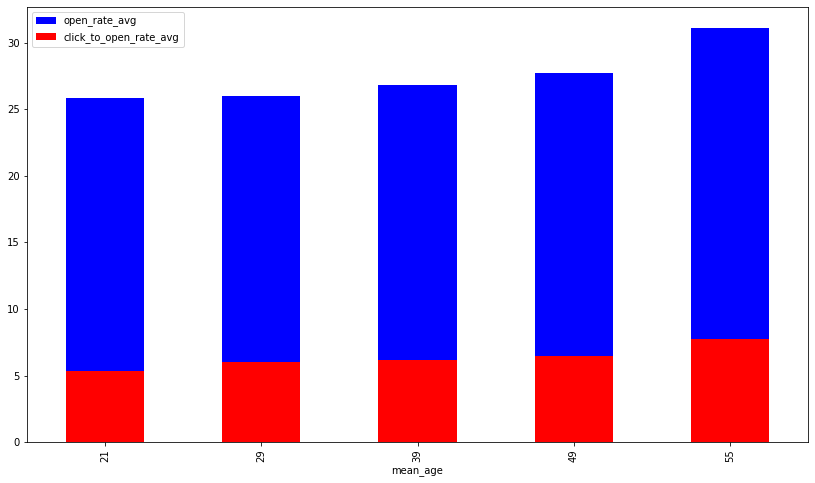

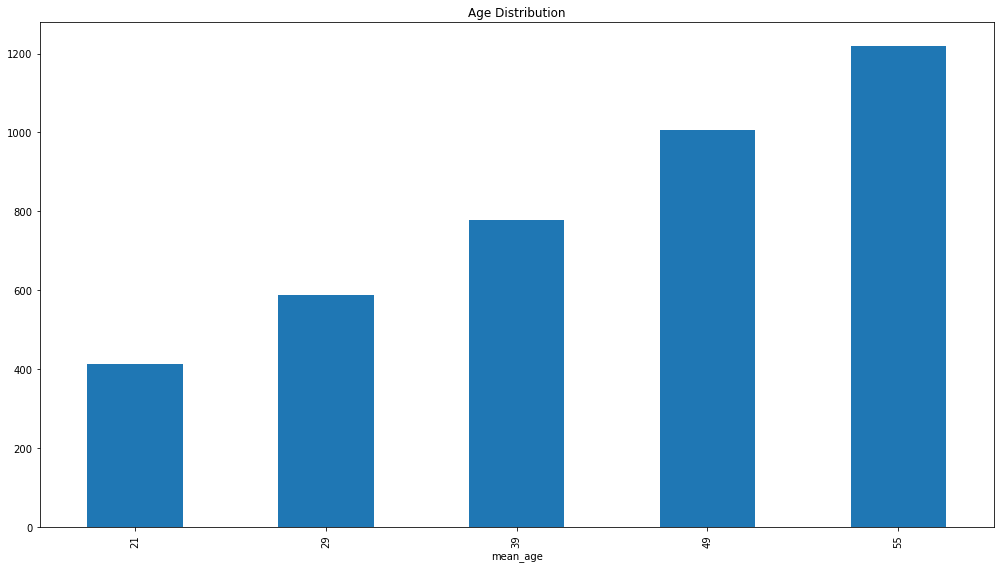

In [887]:
data.groupby('mean_age')['open_rate_avg'].mean().plot.bar(color = 'b')
data.groupby('mean_age')['click_to_open_rate_avg'].mean().plot.bar(color = 'r')
plt.legend()
plt.show()
x = data.groupby('mean_age')['Customer_ID'].count() #/len(data)
x.plot.bar()
plt.title('Age Distribution')
plt.tight_layout()


# Average conversion rate for opening the email and clicking the link in the email¶ based on number of boxes purchased

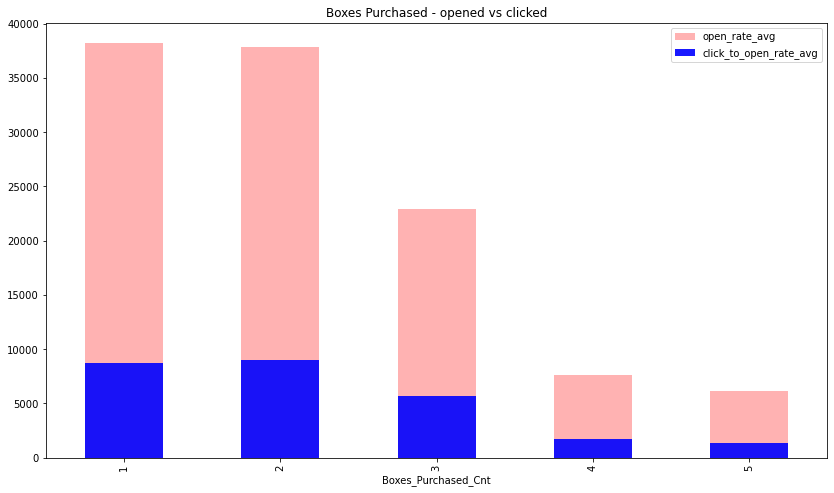

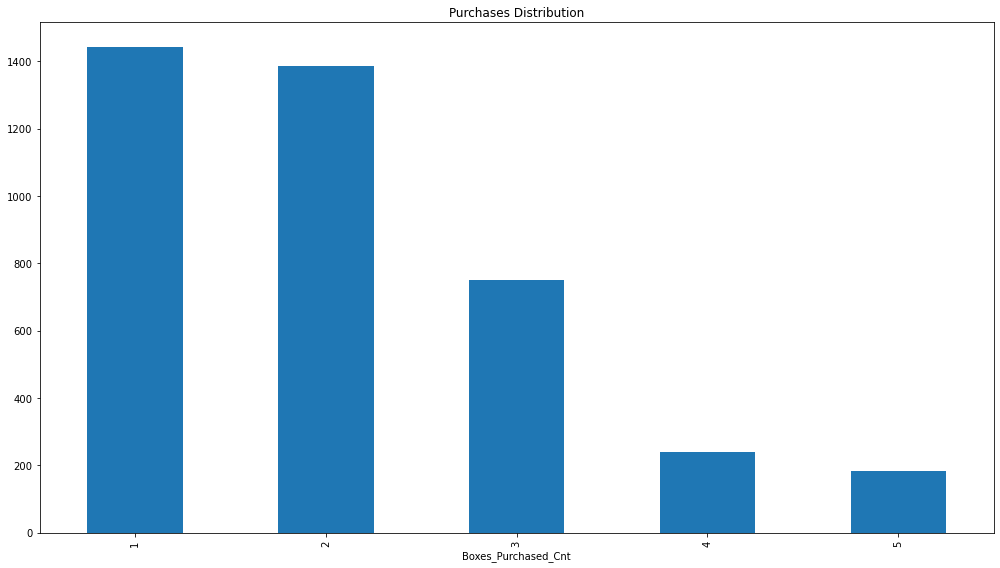

In [888]:

y = data.groupby('Boxes_Purchased_Cnt')['click_to_open_rate_avg'].sum()
x = data.groupby('Boxes_Purchased_Cnt')['open_rate_avg'].sum()

x.plot.bar(color = 'r',alpha = 0.3)
y.plot.bar(color = 'b',alpha = 0.9)
plt.legend()
plt.bar(x,height = 10)
plt.title('Boxes Purchased - opened vs clicked')
plt.show()
x = data.groupby('Boxes_Purchased_Cnt')['Customer_ID'].count() #/len(data)
x.plot.bar()
plt.title('Purchases Distribution')
plt.tight_layout()



# Conversion Rate based on the number of emails sent

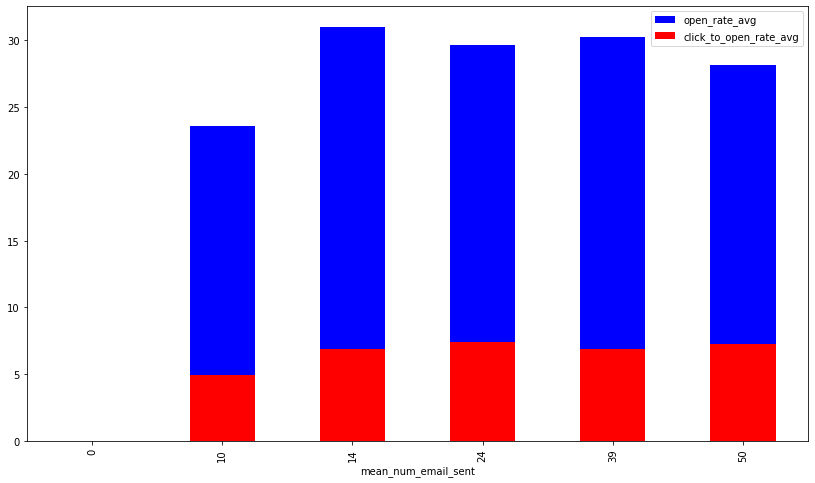

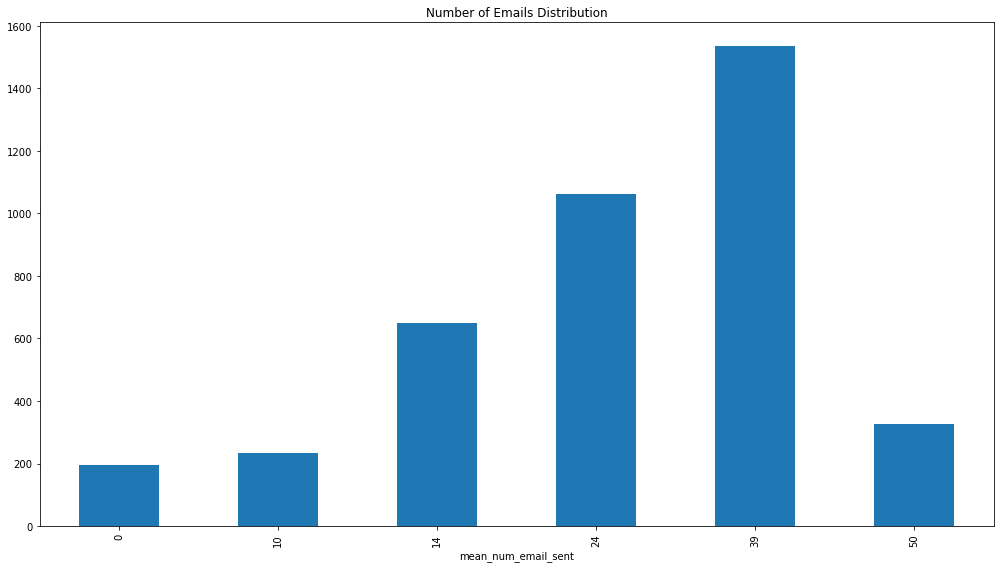

In [889]:
data.groupby('mean_num_email_sent')['open_rate_avg'].mean().plot.bar(color = 'b')
data.groupby('mean_num_email_sent')['click_to_open_rate_avg'].mean().plot.bar(color = 'r')
plt.legend()
plt.show()
x = data.groupby('mean_num_email_sent')['Customer_ID'].count() #/len(data)
x.plot.bar()
plt.title('Number of Emails Distribution')
plt.tight_layout()

# Conversion rate by gender

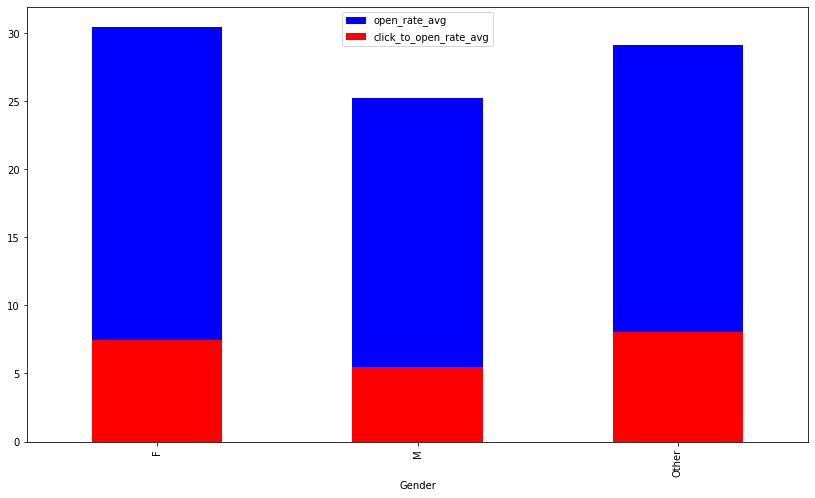

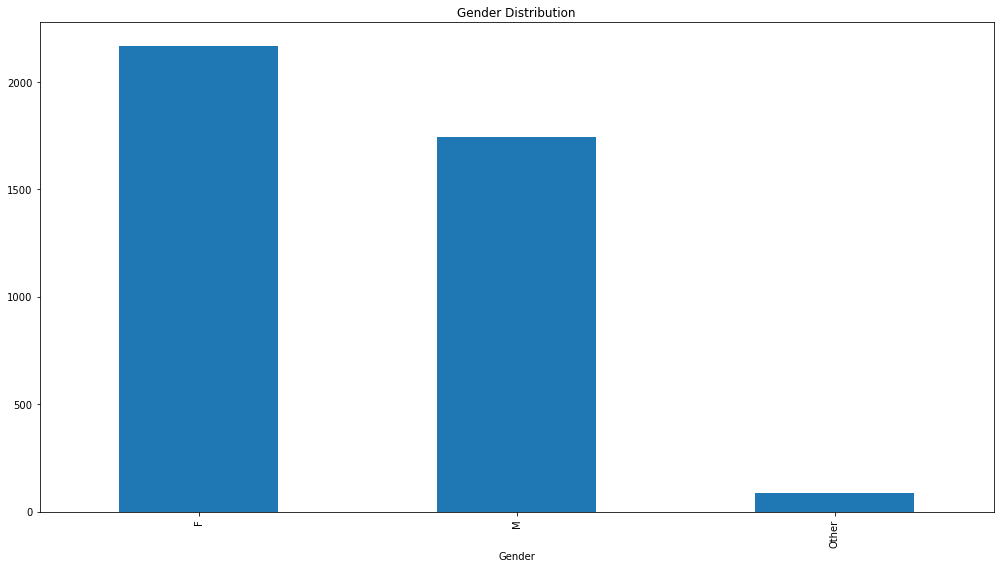

In [890]:
data.groupby('Gender')['open_rate_avg'].mean().plot.bar(color = 'b')
data.groupby('Gender')['click_to_open_rate_avg'].mean().plot.bar(color = 'r')
plt.legend()
plt.show()
x = data.groupby('Gender')['Customer_ID'].count() #/len(data)
x.plot.bar()
plt.title('Gender Distribution')
plt.tight_layout()


# Email Subscription Distribution

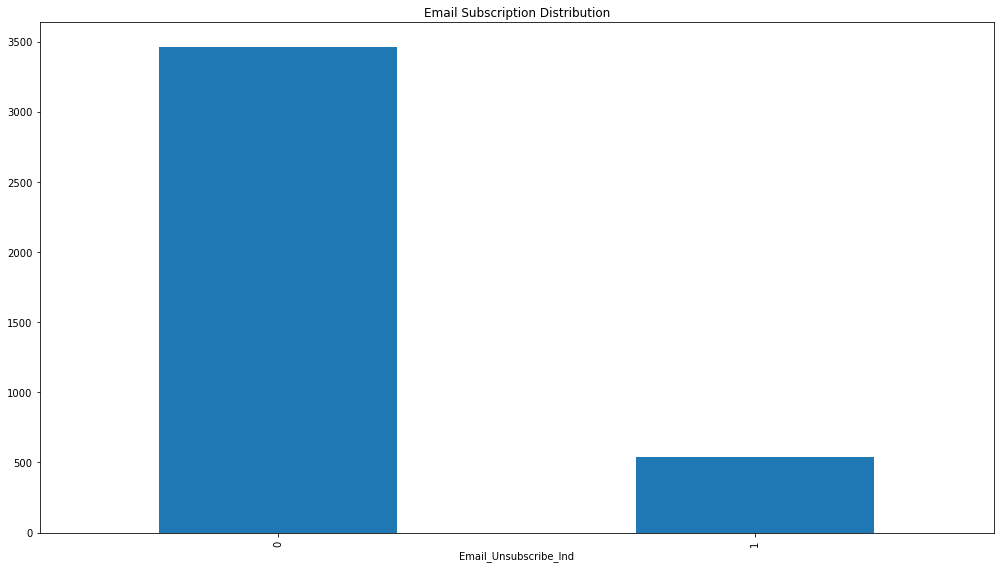

In [891]:
x = data.groupby('Email_Unsubscribe_Ind')['Customer_ID'].count() #/len(data)
x.plot.bar()
plt.title('Email Subscription Distribution')
plt.tight_layout()

# Customer Churn Prediction

# Decision Tree Model for feature importance (Churn)

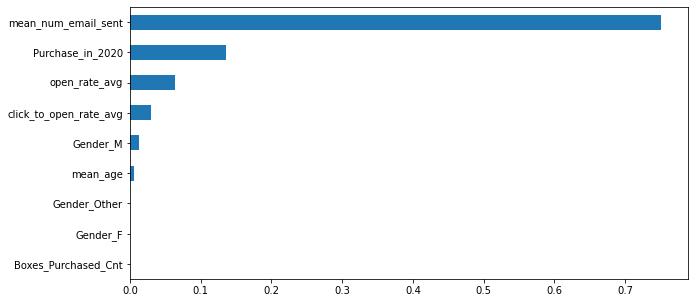

In [892]:
y = data['Email_Unsubscribe_Ind']
train = pd.get_dummies(data.drop(['Customer_ID', 'Customer_Status', 'Email_Unsubscribe_Ind'], axis = 1))

tree = DecisionTreeClassifier(max_depth = 5, class_weight = 'balanced', min_impurity_decrease = 0.001)
tree.fit(train, y)

feat_importances = pd.Series(tree.feature_importances_, 
                             index=train.columns)
feat_importances.sort_values().plot(kind='barh', figsize = (10,5))
plt.show()

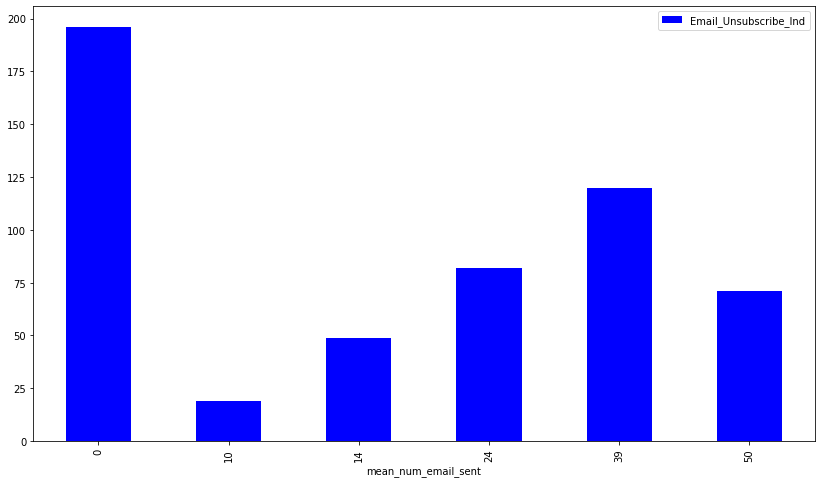

In [893]:
data.groupby('mean_num_email_sent')['Email_Unsubscribe_Ind'].sum().plot.bar(color = 'b')
plt.legend()
plt.show()

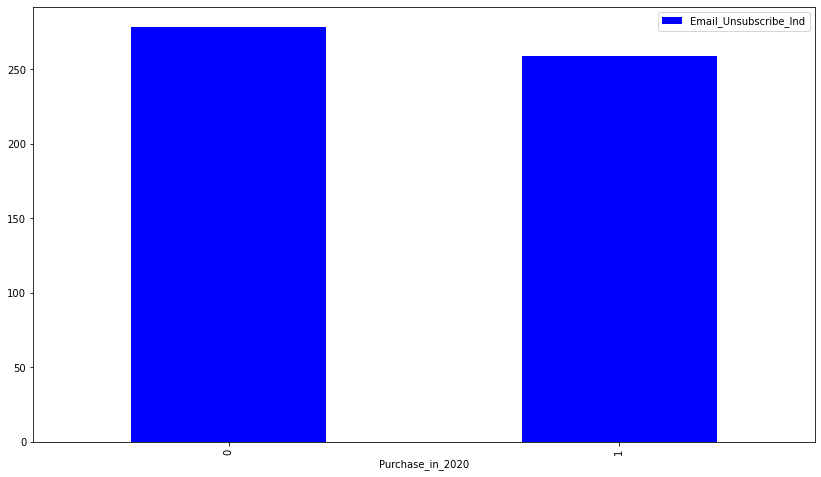

In [997]:
data.groupby('Purchase_in_2020')['Email_Unsubscribe_Ind'].sum().plot.bar(color = 'b')
plt.legend()
plt.show()

# Customer Churn Prediction using Random Forest

In [993]:
# Training
X = data.drop(['Email_Unsubscribe_Ind', 'Customer_ID', 'Customer_Status', 'Gender', 'mean_age','open_rate_avg', 'click_to_open_rate_avg'], axis=1)
Z = data['Email_Unsubscribe_Ind']

from sklearn.model_selection import train_test_split

X_train, X_test, Z_train, Z_test = train_test_split(X, Z, test_size=0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values
Z_train = Z_train.values
Z_test = Z_test.values

from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection

from sklearn.model_selection import cross_val_score


RF = RandomForestClassifier()
RF.fit(X_train, Z_train)
training_score = cross_val_score(RF, X_train, Z_train, cv=5)
print("Classifier: ", RF.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")



Classifier:  RandomForestClassifier Has a training score of 90.0 % accuracy score


In [994]:
# Testing
from sklearn.metrics import accuracy_score

Z_pred_RF = RF.predict(X_test)

print('Random Forest Classifier:')
print(classification_report(Z_test, Z_pred_RF))
print(accuracy_score(Z_test, Z_pred_RF))

Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       703
           1       0.72      0.49      0.59        97

    accuracy                           0.92       800
   macro avg       0.82      0.73      0.77       800
weighted avg       0.91      0.92      0.91       800

0.915


# Conversion Rate Prediction

In [896]:
data['conversion'] = round(data['open_rate_avg']*data['click_to_open_rate_avg']/100, 2)

In [897]:
data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Email_Unsubscribe_Ind,Customer_Status,mean_age,mean_num_email_sent,open_rate_avg,click_to_open_rate_avg,Purchase_in_2020,conversion
0,1,F,2,0,active,29,14,0.0,0.0,1,0.00
1,2,M,1,1,cancel,49,14,62.5,5.0,1,3.12
2,3,M,2,0,active,39,24,37.5,27.5,0,10.31
3,4,F,2,1,active,55,24,0.0,0.0,1,0.00
4,5,M,2,1,active,29,0,0.0,0.0,1,0.00


In [898]:
data['conversion'].unique()

array([ 0.  ,  3.12, 10.31,  1.88,  7.5 ,  7.81,  0.62,  2.5 ,  4.69,
       10.94,  1.56,  3.44, 17.19,  4.38, 12.5 , 24.06, 17.5 ])

<AxesSubplot:>

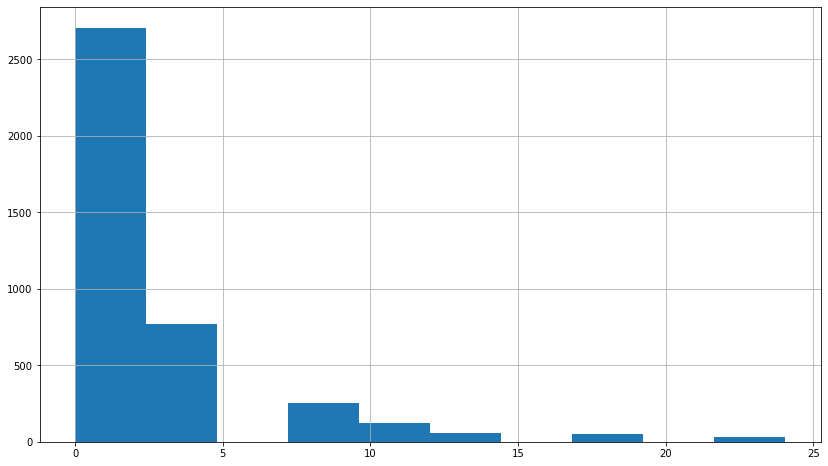

In [899]:
data['conversion'].hist()

In [900]:
data['conversion'].mean()

2.5196750000000057

We convert the conversion rate value to binary

In [1022]:
# We assume that a conversion rate of 5% and above is high and we show it with 1.

def mapper(x):
    if x>= 5:
        return 1
    elif x< 5:
        return 0
data['conversion_binary'] = data['conversion'].apply(mapper)

In [1023]:
conversion_binary = data['conversion_binary']

In [1024]:
data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Email_Unsubscribe_Ind,Customer_Status,mean_age,mean_num_email_sent,open_rate_avg,click_to_open_rate_avg,Purchase_in_2020,conversion,conversion_binary,Male
0,1,F,2,0,active,29,14,0.0,0.0,1,0.00,0,0
1,2,M,1,1,cancel,49,14,62.5,5.0,1,3.12,0,1
2,3,M,2,0,active,39,24,37.5,27.5,0,10.31,1,1
3,4,F,2,1,active,55,24,0.0,0.0,1,0.00,0,0
4,5,M,2,1,active,29,0,0.0,0.0,1,0.00,0,1


# Decision Tree Model for feature importance (Conversion Rate)

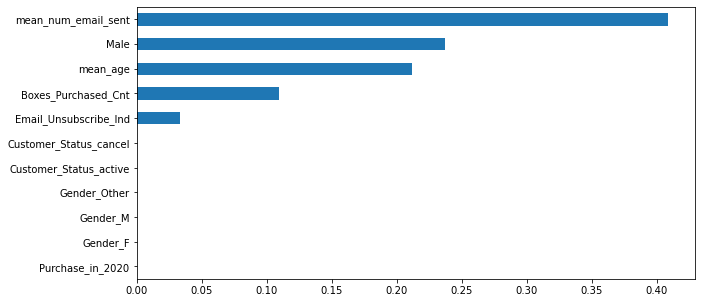

In [1018]:
y = data['conversion_binary']
train = pd.get_dummies(data.drop(['Customer_ID', 'conversion_binary', 'conversion', 'click_to_open_rate_avg', 'open_rate_avg'], axis = 1))

tree = DecisionTreeClassifier(max_depth = 5, class_weight = 'balanced', min_impurity_decrease = 0.001)
tree.fit(train, y)

feat_importances = pd.Series(tree.feature_importances_, 
                             index=train.columns)
feat_importances.sort_values().plot(kind='barh', figsize = (10,5))
plt.show()

In [1019]:
def gen_model(n):
    if n == 'M':
        return 1
    else:
        return 0
data['Male'] = data['Gender'].apply(gen_model)
Male = data['Male']

data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Email_Unsubscribe_Ind,Customer_Status,mean_age,mean_num_email_sent,open_rate_avg,click_to_open_rate_avg,Purchase_in_2020,conversion,conversion_binary,Male
0,1,F,2,0,active,29,14,0.0,0.0,1,0.00,0,0
1,2,M,1,1,cancel,49,14,62.5,5.0,1,3.12,0,1
2,3,M,2,0,active,39,24,37.5,27.5,0,10.31,1,1
3,4,F,2,1,active,55,24,0.0,0.0,1,0.00,0,0
4,5,M,2,1,active,29,0,0.0,0.0,1,0.00,0,1


# Conversion Rate Prediction using Random Forest

In [1025]:
# Training
A = data.drop(['conversion_binary', 'Customer_ID','Gender','Boxes_Purchased_Cnt','Email_Unsubscribe_Ind','conversion','Purchase_in_2020', 'Customer_Status', 'click_to_open_rate_avg', 'open_rate_avg'], axis=1)
B = data['conversion_binary']

from sklearn.model_selection import train_test_split

A_train, A_test, B_train, B_test = train_test_split(A, B, test_size=0.2, random_state=42)

A_train = A_train.values
A_test = A_test.values
B_train = B_train.values
B_test = B_test.values

from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection

from sklearn.model_selection import cross_val_score


RF2 = RandomForestClassifier()
RF2.fit(A_train, B_train)
training_score = cross_val_score(RF2, A_train, B_train, cv=5)
print("Classifier: ", RF2.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")


Classifier:  RandomForestClassifier Has a training score of 87.0 % accuracy score


In [1026]:
# Testing
from sklearn.metrics import accuracy_score

B_pred_RF = RF2.predict(A_test)

print('Random Forest Classifier:')
print(classification_report(B_test, B_pred_RF))
print(accuracy_score(B_test, B_pred_RF))

Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       692
           1       0.00      0.00      0.00       108

    accuracy                           0.86       800
   macro avg       0.43      0.50      0.46       800
weighted avg       0.75      0.86      0.80       800

0.865


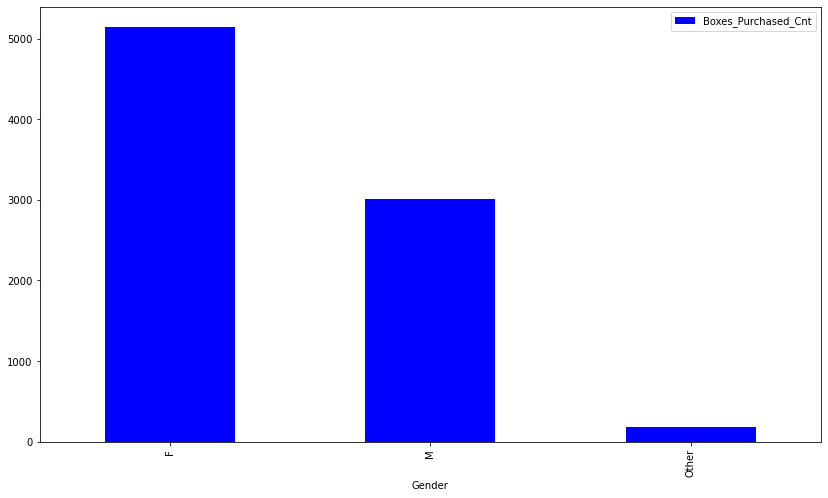

In [1021]:
data.groupby('Gender')['Boxes_Purchased_Cnt'].sum().plot.bar(color = 'b')
plt.legend()
plt.show()